<h2 align=center> Classify Radio Signals from Outer Space with Keras</h2>

![](Allen_Telescope.jpg)
[Allen Telescope Array](https://flickr.com/photos/93452909@N00/5656086917) by [brewbooks](https://www.flickr.com/people/93452909@N00) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/)

## Task 1: Import Libraries

In [1]:
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Task 2: Load and Preprocess SETI Data

In [2]:
train_images = pd.read_csv('dataset/train/images.csv', header = None)
train_labels = pd.read_csv('dataset/train/labels.csv', header = None)

val_images = pd.read_csv('dataset/validation/images.csv', header = None)
val_labels = pd.read_csv('dataset/validation/labels.csv', header = None)

In [3]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [4]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [5]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


In [6]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Task 3: Plot 2D Spectrograms

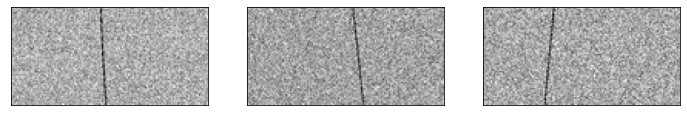

In [7]:
plt.figure(0, figsize = (12, 12))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    img = np.squeeze(x_train[np.random.randint(0, x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")

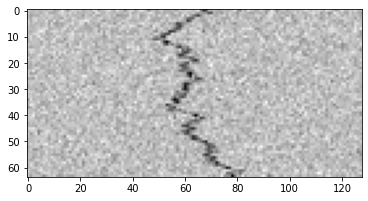

In [8]:
plt.imshow(np.squeeze(x_train[3]), cmap = "gray");

## Task 4: Create Training and Validation Data Generators

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_val.fit(x_val)

## Task 5: Creating the CNN Model

In [10]:
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64, (5, 5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation = 'softmax'))

## Task 6: Learning Rate Scheduling and Compile the Model

In [12]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True)

optimizer = Adam(learning_rate = lr_schedule)

In [13]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

In [15]:
from livelossplot import PlotLossesKeras

## Task 7: Training the Model

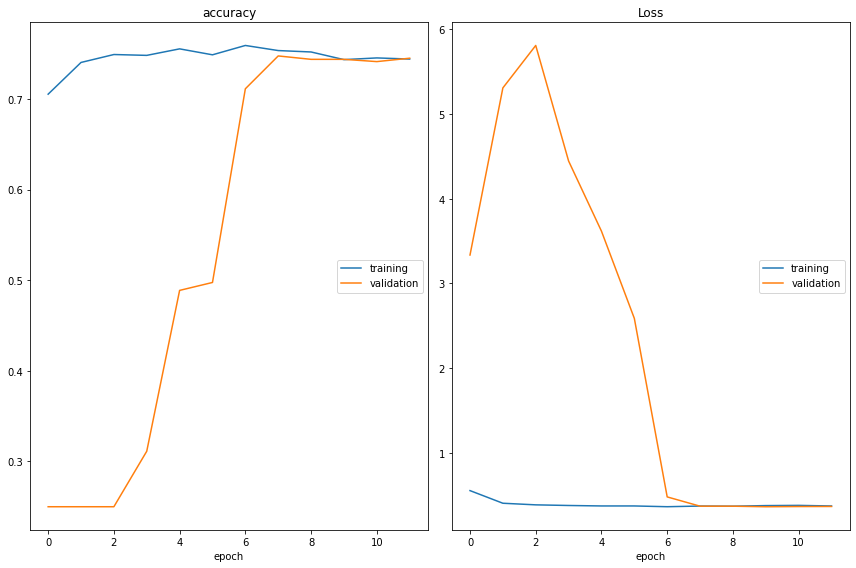

accuracy
	training         	 (min:    0.705, max:    0.759, cur:    0.744)
	validation       	 (min:    0.250, max:    0.748, cur:    0.745)
Loss
	training         	 (min:    0.363, max:    0.554, cur:    0.372)
	validation       	 (min:    0.363, max:    5.809, cur:    0.366)
100/100 [==============================] - 103s 1s/step - loss: 0.3719 - accuracy: 0.7441 - val_loss: 0.3663 - val_accuracy: 0.7450


In [16]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor = 'val_loss',
                             save_weights_only = True, mode = 'min', verbose = 0)

callbacks = [PlotLossesKeras(), checkpoint, ]

batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size = batch_size, shuffle = True),
    steps_per_epoch = len(x_train) // batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size = batch_size, shuffle = True),
    validation_steps = len(x_val) // batch_size,
    epochs = 12,
    callbacks = callbacks
)

## Task 8: Model Evaluation

In [17]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 3s 108ms/step - loss: 0.3657 - accuracy: 0.7475


[0.36566516757011414, 0.7475000023841858]

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.50      0.88      0.64       200
           2       0.50      0.13      0.21       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.71       800
weighted avg       0.75      0.75      0.71       800



In [19]:
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

Classification accuracy: 0.747500


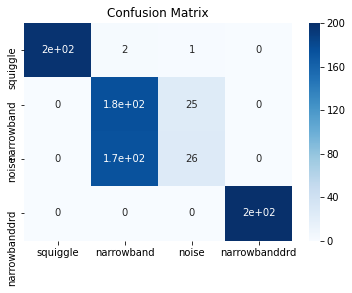

In [21]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax = plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True, ax = ax, cmap = plt.cm.Blues);
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);